In [ ]:
#### 01.01.2021 Klaudia Dikunow ####
#### Data source: https://www.kaggle.com/c/cassava-leaf-disease-classification/data ####

## 1. Importing libraries & main variables

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
import cv2
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from PIL import Image, ImageStat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
base_path = 'D:/kaggle/Cassava leaf/cassava-leaf-disease-classification'
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 200

In [4]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)

## 2. Loading data

In [5]:
df = pd.read_csv(base_path+'/train.csv')
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [6]:
target_names = json.load(open(base_path+'/label_num_to_disease_map.json'))
df['disease_name'] = df['label'].apply(lambda x: target_names[str(x)])
df.head()

image_id  label                         disease_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

## 3. Explanatory Data Analysis

### 3.1. Diseases distributions

In [7]:
df['disease_name'].value_counts()

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: disease_name, dtype: int64

In [8]:
diseases = df['disease_name'].value_counts().index

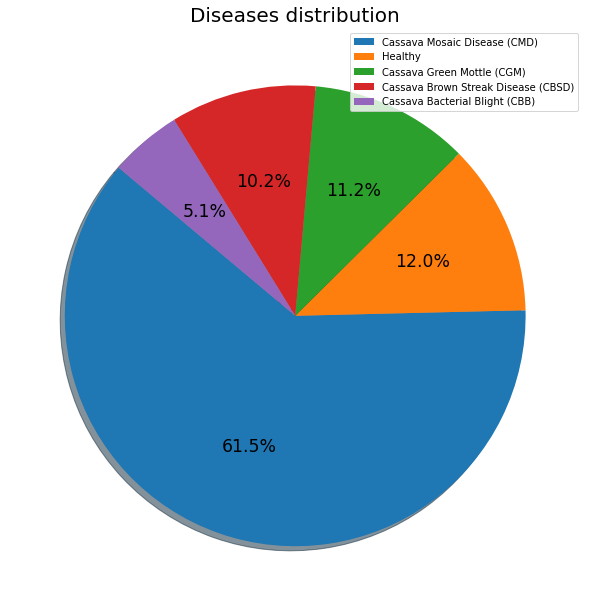

In [9]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title('Diseases distribution', fontsize=20)

patches, texts, autotexts = ax.pie(df['disease_name'].value_counts(), autopct='%1.1f%%',
                                  shadow=True, startangle=140)

ax.legend(patches, diseases, loc='upper right')
proptease = fm.FontProperties()
proptease.set_size('xx-large')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

### 3.2. Sample images from each target class

In [10]:
def show_sample_imgs(disease):
    k=1
    plt.figure(figsize=(12,7))
    plt.suptitle(diseases[disease], y=0.9)
    for j in range(6):
            im = df[df['disease_name'] == diseases[disease]].iloc[np.random.randint(df[df['disease_name'] == diseases[disease]].shape[0]),0]
            path = base_path+'/train_images/' + im
            image = Image.open(path)

            plt.subplot(2,3,k)
            plt.imshow(image)
            k+=1

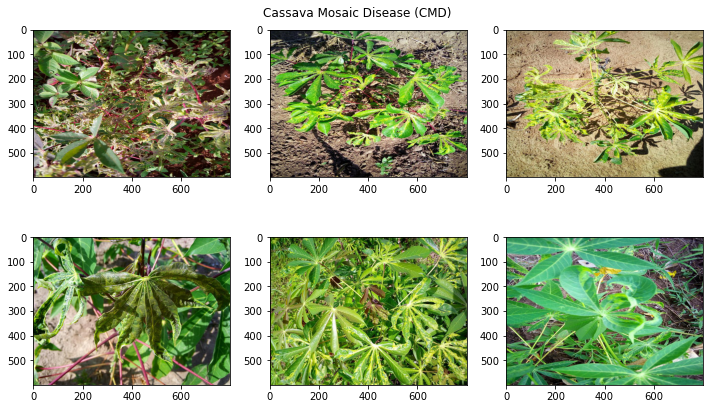

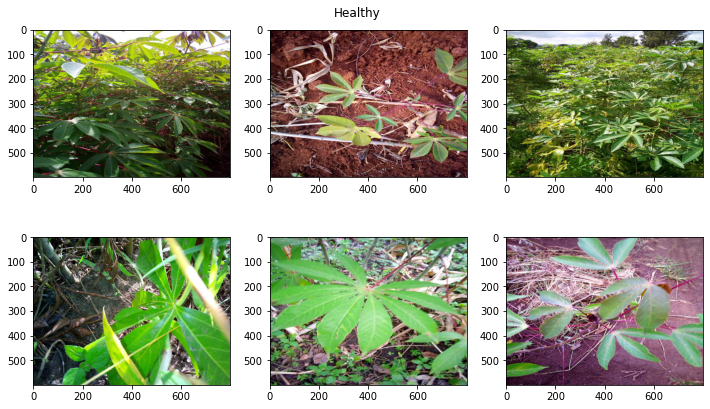

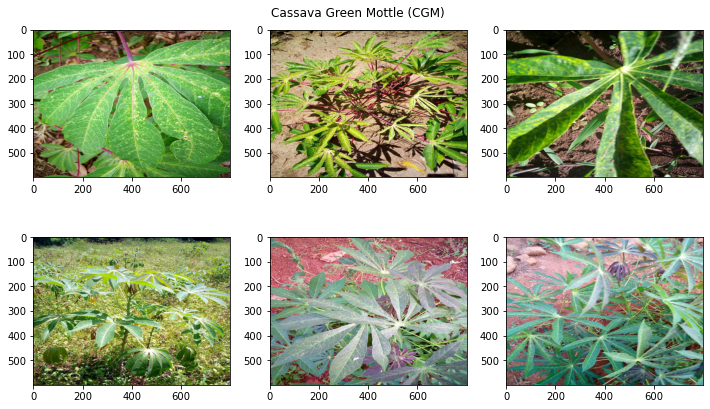

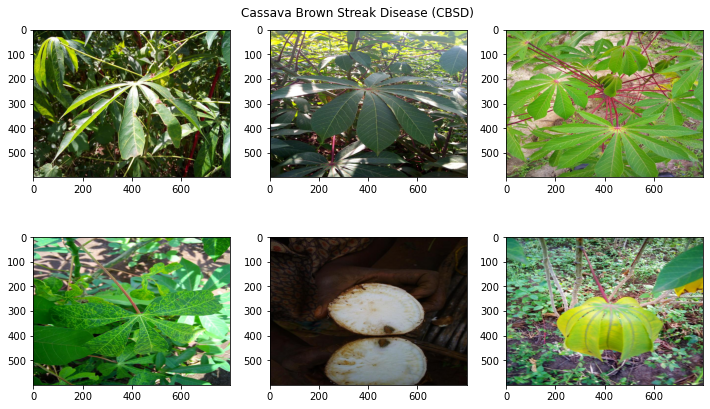

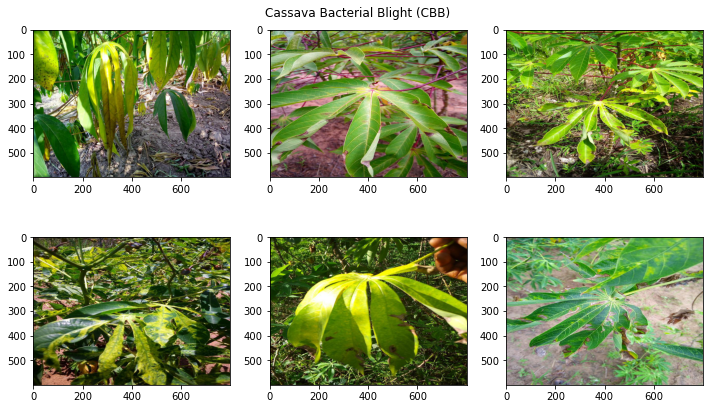

In [11]:
for i in range(5):
    show_sample_imgs(i)

### 3.3. Median channel values for each disease

In [12]:
def load_image(image_id):
    image = cv2.imread(base_path + '/train_images/' + image_id)
    
    scale_percent = 50 
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    return cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

In [13]:
def ChannelValues(images):
    imageArray = [load_image(image_id) for image_id in images]
    
    red_values = np.median([np.mean(imageArray[idx][:, :, 0]) for idx in range(len(imageArray))])
    green_values = np.median([np.mean(imageArray[idx][:, :, 1]) for idx in range(len(imageArray))])
    blue_values = np.median([np.mean(imageArray[idx][:, :, 2]) for idx in range(len(imageArray))])
    
    hist_data = [red_values, green_values, blue_values]
    return hist_data

In [14]:
healthyImages = df[df['disease_name'] == 'Healthy']['image_id'].to_list()
CMDImages = df[df['disease_name'] == 'Cassava Mosaic Disease (CMD)']['image_id'].to_list()
CGMImages = df[df['disease_name'] == 'Cassava Green Mottle (CGM)']['image_id'].to_list()
CBSDImages = df[df['disease_name'] == 'Cassava Brown Streak Disease (CBSD)']['image_id'].to_list()
CBBImages = df[df['disease_name'] == 'Cassava Bacterial Blight (CBB)']['image_id'].to_list()

#### Healthy

In [14]:
healthy_channels = ChannelValues(healthyImages)

In [15]:
healthy_red = healthy_channels[0]
healthy_green = healthy_channels[1]
healthy_blue = healthy_channels[2]

#### CMD

In [16]:
CMD_channels = ChannelValues(CMDImages)

In [17]:
CMD_red = CMD_channels[0]
CMD_green = CMD_channels[1]
CMD_blue = CMD_channels[2]

#### CGM

In [18]:
CGM_channels = ChannelValues(CGMImages)

In [19]:
CGM_red = CGM_channels[0]
CGM_green = CGM_channels[1]
CGM_blue = CGM_channels[2]

#### CBSD

In [20]:
CBSD_channels = ChannelValues(CBSDImages)

In [21]:
CBSD_red = CBSD_channels[0]
CBSD_green = CBSD_channels[1]
CBSD_blue = CBSD_channels[2]

#### CBB

In [22]:
CBB_channels = ChannelValues(CBBImages)

In [23]:
CBB_red = CBB_channels[0]
CBB_green = CBB_channels[1]
CBB_blue = CBB_channels[2]

#### Summary

In [24]:
summary = pd.DataFrame([{'disease': 'Healthy', 'red': healthy_red, 'green': healthy_green, 'blue': healthy_blue},
                       {'disease': 'CMD', 'red': CMD_red, 'green': CMD_green, 'blue': CMD_blue},
                       {'disease': 'CGM', 'red': CGM_red, 'green': CGM_green, 'blue': CGM_blue},
                       {'disease': 'CBSD', 'red': CBSD_red, 'green': CBSD_green, 'blue': CBSD_blue},
                       {'disease': 'CBB', 'red': CBB_red, 'green': CBB_green, 'blue': CBB_blue}])

In [25]:
summary

disease         red       green       blue
0  Healthy  108.537017  126.484983  80.128917
1      CMD  110.258217  128.483829  79.760967
2      CGM  114.031808  128.865204  85.442479
3     CBSD  106.251650  123.971483  72.878050
4      CBB  102.586000  117.172883  66.432275

In [ ]:
# In CBB disease the values in every channel are the lowest. The highest values in each channel are noted for CGM diseases.

## 4. Image augmentation

#### Selecting subsample because of performance 

In [21]:
df, df_test = train_test_split(df, test_size = 0.5)

In [23]:
train_datagen = ImageDataGenerator(validation_split = 0.2,
                                   rotation_range = 20,
                                   zoom_range = 0.25,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1,
                                   brightness_range = [0.4,1.5])

In [25]:
df['label']=df['label'].astype('str')

<ipython-input-25-e6dc75af9405>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['label'].astype('str')


In [27]:
train_generator = train_datagen.flow_from_dataframe(df,
                         directory = base_path + '/train_images/',
                         x_col = "image_id",
                         y_col = "label",
                         class_mode = "categorical",
                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                         batch_size = BATCH_SIZE,                           
                         subset = "training"
                         )

Found 8559 validated image filenames belonging to 5 classes.


In [28]:
valid_datagen = ImageDataGenerator(validation_split = 0.2)

In [29]:
valid_generator = valid_datagen.flow_from_dataframe(df,
                         directory = base_path + '/train_images/',
                         x_col = "image_id",
                         y_col = "label",
                         class_mode = "categorical",
                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                         batch_size = BATCH_SIZE,       
                         subset = "validation"
                         )

Found 2139 validated image filenames belonging to 5 classes.


#### Displaying few augmentations

In [30]:
generator = train_datagen.flow_from_dataframe(df.iloc[10:11],
                         directory = base_path + '/train_images/',
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


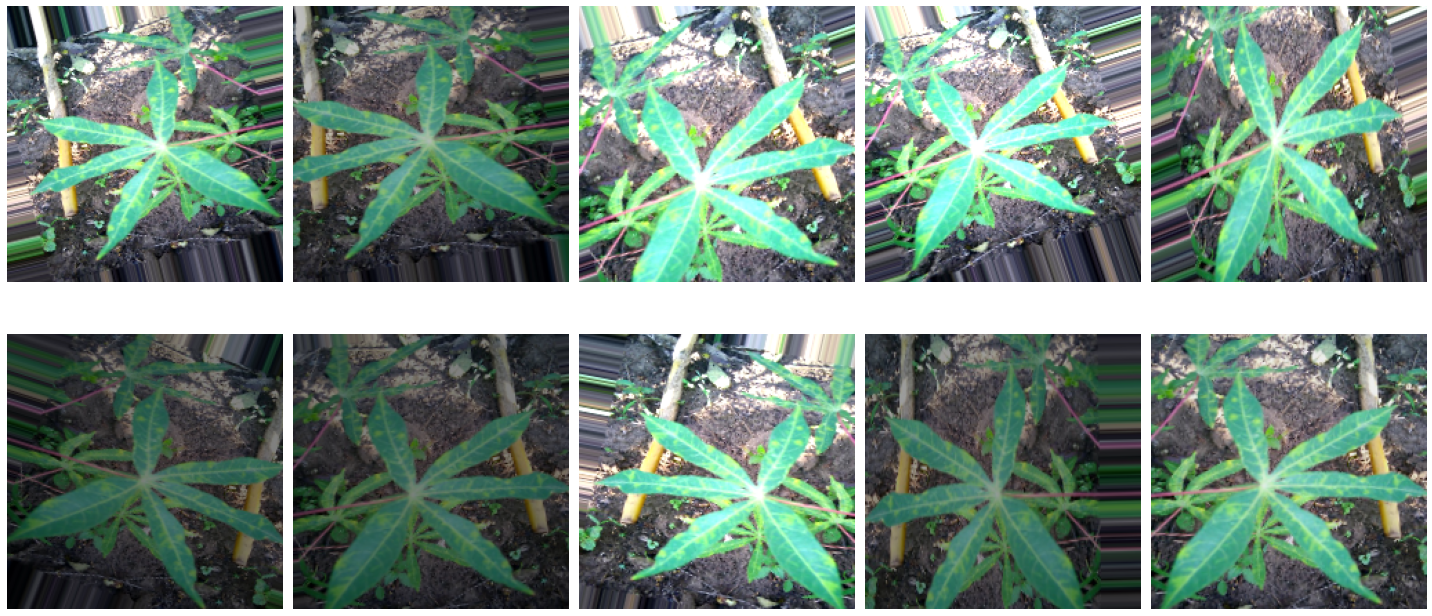

In [31]:
aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 5. Creating a baseline model

In [32]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

In [36]:
history = model.fit_generator(train_generator, 
                    epochs=EPOCHS,  
                    steps_per_epoch=len(df)*0.8 // BATCH_SIZE,  
                    validation_data=valid_generator,
                    validation_steps=len(df)*0.2 // BATCH_SIZE)

C:\Users\klaud\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
267/267 [==============================] - 400s 1s/step - loss: 16.6196 - accuracy: 0.5428 - val_loss: 1.2982 - val_accuracy: 0.5999
Epoch 2/20
267/267 [==============================] - 394s 1s/step - loss: 1.3234 - accuracy: 0.6177 - val_loss: 1.1357 - val_accuracy: 0.6089
Epoch 3/20
267/267 [==============================] - 391s 1s/step - loss: 1.1542 - accuracy: 0.6195 - val_loss: 1.1011 - val_accuracy: 0.6113
Epoch 4/20
267/267 [==============================] - 394s 1s/step - loss: 1.0662 - accuracy: 0.6351 - val_loss: 1.0232 - val_accuracy: 0.6245
Epoch 5/20
267/267 [==============================] - 398s 1s/step - loss: 1.0783 - accuracy: 0.6187 - val_loss: 1.0281 - val_accuracy: 0.6184
Epoch 6/20
267/267 [==============================] - 394s 1s/step - loss: 1.0325 - accuracy: 0.6275 - val_loss: 1.0504 - val_accuracy: 0.6250
Epoch 7/20
267/267 [==============================] - 380s 1s/step - loss: 1.0246 - accuracy: 0.6264 - val_loss: 0.9958 - val_accuracy: 0.625

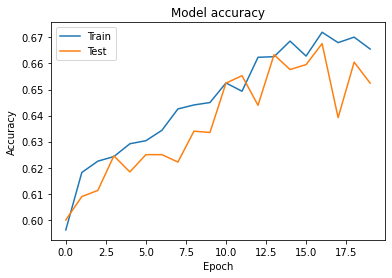

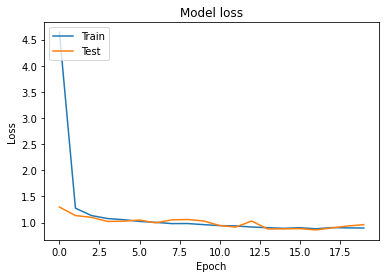

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 6. Developing more complex model

#### Callbacks

In [38]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    './best_weights.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [39]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [40]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    mode="min",
    min_delta=0.001,
)

#### Model with callbacks and dropout layers

In [41]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))
model2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(5, activation='softmax'))

In [42]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 128)      

In [44]:
history2 = model2.fit_generator(train_generator, 
                    epochs=EPOCHS,  
                    steps_per_epoch=len(df)*0.8 // BATCH_SIZE,  
                    validation_data=valid_generator,
                    validation_steps=len(df)*0.2 // BATCH_SIZE,
                    callbacks = [model_checkpoint, early_stopping, reduce_lr])

Epoch 1/20
267/267 [==============================] - 427s 2s/step - loss: 46.5298 - accuracy: 0.5340 - val_loss: 1.5133 - val_accuracy: 0.6080

Epoch 00001: val_loss improved from inf to 1.51332, saving model to .\best_weights.h5
Epoch 2/20
267/267 [==============================] - 424s 2s/step - loss: 1.2677 - accuracy: 0.6214 - val_loss: 1.4245 - val_accuracy: 0.6094

Epoch 00002: val_loss improved from 1.51332 to 1.42451, saving model to .\best_weights.h5
Epoch 3/20
267/267 [==============================] - 423s 2s/step - loss: 1.1986 - accuracy: 0.6194 - val_loss: 1.3679 - val_accuracy: 0.6103

Epoch 00003: val_loss improved from 1.42451 to 1.36787, saving model to .\best_weights.h5
Epoch 4/20
267/267 [==============================] - 431s 2s/step - loss: 1.1875 - accuracy: 0.6238 - val_loss: 1.3276 - val_accuracy: 0.6089

Epoch 00004: val_loss improved from 1.36787 to 1.32762, saving model to .\best_weights.h5
Epoch 5/20
267/267 [==============================] - 432s 2s/step 

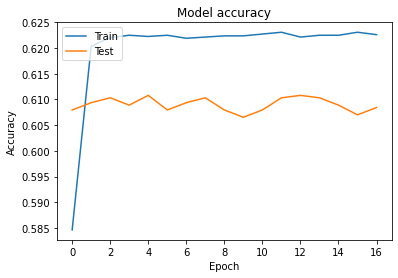

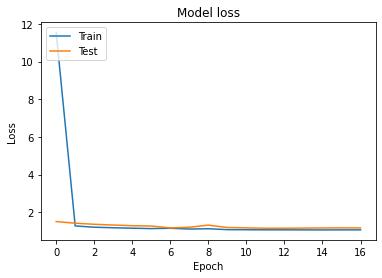

In [45]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Conclusion: Adding callbacks and dropout layers did not improve model accuracy and model loss.